<a href="https://colab.research.google.com/github/QasimKhan5x/Crop-Type-Mapping/blob/main/Create_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%%shell
sudo add-apt-repository ppa:ubuntugis/ppa
sudo apt-get update
sudo apt-get install python-numpy gdal-bin libgdal-dev
pip install rasterio geopandas fastparquet

In [1]:
import os
import glob
from pathlib import Path
from pprint import pprint
import gc

import rasterio as rio
from rasterio.features import rasterize
from tqdm.notebook import tqdm
import numpy as np
import pandas as pd
from scipy import ndimage 
import geopandas as gpd
from matplotlib import pyplot as plt
from rasterio.plot import show, show_hist

In [2]:
idx2label = {
    1: "cassava",
    2: "rice",
    3: "maize", 
    4: "sugarcane"
}

## Create Data

In [3]:
grid_aoi = gpd.read_file('/content/drive/MyDrive/VarunaHackathon2022/Grid_AOI/AOI.shp')
train_aoi = gpd.read_file('/content/drive/MyDrive/VarunaHackathon2022/training_area/traindata.shp')
test_aoi = gpd.read_file('/content/drive/MyDrive/VarunaHackathon2022/testing_area/testdata.shp')

In [4]:
f2020 = '/content/drive/MyDrive/VarunaHackathon2022/sentinel-2-image/2020'
f2021 = '/content/drive/MyDrive/VarunaHackathon2022/sentinel-2-image/2021'

In [5]:
print(len(os.listdir(f2020)))
print(len(os.listdir(f2021)))

71
71


In [6]:
reference_image_path = '/content/drive/MyDrive/VarunaHackathon2022/sentinel-2-image/2021/20210101/IMG_DATA/47PQS_20210101_B02.jp2'
reference_image = rio.open(reference_image_path)
reference_image.shape

(2051, 2051)

Class pixel count: {1: 100162, 2: 29069, 3: 84342, 4: 23309}
Total Non-zero pixels: 236882


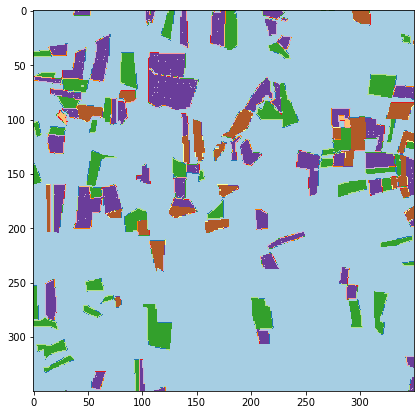

In [7]:
profile = reference_image.profile
label = train_aoi.to_crs(profile['crs'])
target_image = rasterize(
    shapes=[(row.geometry, int(row.crop_type)) for i, row in label.iterrows()],
    out_shape=(profile['width'], profile['height']),
    transform=profile['transform']
    )
classes, pixel_counts = np.unique(target_image, return_counts=True)
print('Class pixel count:', dict(zip(classes[1:], pixel_counts[1:])))
print('Total Non-zero pixels:', pixel_counts[1:].sum())
plt.figure(figsize=(7,7))
plt.imshow(target_image[750:1100, 1250:1600], cmap='Paired')

In [8]:
def resample_3d(
        stack,
        row10m,
        col10m,
        rate):
    row, col, bands = stack.shape
    # print("Array shape (%d,%d,%d)" % (row, col, bands))
    stack_10m = np.zeros((row10m, col10m, bands),dtype=np.uint16)
    # print("Resize array bands from (%d,%d,%d) to (%d,%d,%d)" % (
        # row, col, bands, row10m, col10m, bands))
    for i in range(bands):
        zoomed_arr = ndimage.zoom(stack[:, :, i], rate)
        if zoomed_arr.shape[0] > row10m:
            # reduce by 1 row and 1 column
            zoomed_arr = zoomed_arr[:-1, :-1]
        elif zoomed_arr.shape[0] < row10m:
            # pad by 1 row and 1 column
            zoomed_arr = np.pad(zoomed_arr, 1, mode='edge')[1:, 1:]
        stack_10m[:, :, i] = zoomed_arr
    del stack
    return stack_10m

In [22]:
required_bands = ['B8A'] + [f'B0{i}' for i in range(2,9)] + ['B11', 'B12']
required_bands.sort()
required_bands[-1], required_bands[-3] = required_bands[-3], required_bands[-1]
required_bands[-1], required_bands[-2] = required_bands[-2], required_bands[-1]
required_bands

['B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B8A', 'B11', 'B12']

In [10]:
def read_bands(img_data):
    ''' 2051 x 2051 x 10 '''
    jp2_imgs = '*.jp2'
    path = os.path.join(img_data, jp2_imgs)
    files = glob.glob(path)
    req_files = [file for file in files if file[-7:-4] in required_bands]
    # 10m resolution bands
    tenM = ['02', '03', '04', '08']
    # 10M shape is (2051, 2051)
    bands = np.zeros((2051, 2051, 10))
    for i, file in enumerate(req_files):
        arr = rio.open(file).read()
        # print(f'B{file[-6:-4]}', arr.shape)
        if file[-6:-4] in tenM:
            bands[:, :, i] = arr.squeeze()
        else:
            arr = np.transpose(arr, (1, 2, 0))
            bands[:, :, i] = resample_3d(arr, 2051, 2051, 2).squeeze()
    return bands

In [11]:
def create_dataset(year_path):
    final = pd.DataFrame()
    # iterate over every crop
    for c in classes[1:]:
        print("Creating rows for " + idx2label[c])
        temp = pd.DataFrame()
        for i, timestamp in enumerate(tqdm(os.listdir(f2021))):
            img_data = os.path.join(year_path, timestamp, "IMG_DATA")
            bands = read_bands(img_data)
            # select only those pixels that belong to class c
            req_bands = bands[target_image == c]
            bands_df = pd.DataFrame(req_bands, columns=[f"{timestamp}_{band}" for band in required_bands])
            bands_df.reset_index(drop=True, inplace=True)
            temp = pd.concat([bands_df,temp], axis=1)
            temp["class"] = idx2label[c]
        final = pd.concat([temp,final],axis=0)
        final.reset_index(drop=True,inplace=True)
        gc.collect()
        print("=====================================")
    return final

In [12]:
ds = create_dataset(f2021)

Creating rows for cassava


  0%|          | 0/71 [00:00<?, ?it/s]

Creating rows for rice


  0%|          | 0/71 [00:00<?, ?it/s]

Creating rows for maize


  0%|          | 0/71 [00:00<?, ?it/s]

Creating rows for sugarcane


  0%|          | 0/71 [00:00<?, ?it/s]

In [13]:
print(ds.shape)
ds.head()

(236882, 711)


,20211222_B02,20211222_B03,20211222_B04,20211222_B05,20211222_B06,20211222_B07,20211222_B08,20211222_B8A,20211222_B12,20211222_B11,...,20210210_B03,20210210_B04,20210210_B05,20210210_B06,20210210_B07,20210210_B08,20210210_B8A,20210210_B12,20210210_B11,class
0,1120.0,1531.0,2076.0,3261.0,3864.0,3578.0,3650.0,4470.0,3255.0,4794.0,...,6865.0,6780.0,6370.0,6510.0,6430.0,7004.0,6278.0,6553.0,6004.0,sugarcane
1,1138.0,1535.0,2035.0,3280.0,3896.0,3601.0,3540.0,4507.0,3290.0,4797.0,...,6952.0,6878.0,6503.0,6698.0,6572.0,7198.0,6446.0,6687.0,6066.0,sugarcane
2,1183.0,1567.0,2130.0,3195.0,3822.0,3539.0,3619.0,4391.0,3247.0,4720.0,...,7004.0,6953.0,6540.0,6755.0,6595.0,7254.0,6474.0,6740.0,6052.0,sugarcane
3,1235.0,1618.0,2179.0,2966.0,3572.0,3351.0,3601.0,4050.0,3075.0,4465.0,...,6967.0,6904.0,6450.0,6652.0,6474.0,7296.0,6344.0,6681.0,5970.0,sugarcane
4,883.0,1430.0,1887.0,2586.0,3108.0,3009.0,3090.0,3460.0,2731.0,3891.0,...,6944.0,6921.0,6314.0,6522.0,6306.0,7281.0,6214.0,6571.0,5887.0,sugarcane


In [14]:
ds.to_parquet("/content/drive/MyDrive/VarunaOutput/final.parquet", index=False)

In [15]:
del ds

## Calculate Vegetation Indices

In [3]:
ds_path = '/content/drive/MyDrive/VarunaOutput/final.parquet'
ds = pd.read_parquet(ds_path)
print(ds.shape)
ds.head()

(236882, 711)


,20211222_B02,20211222_B03,20211222_B04,20211222_B05,20211222_B06,20211222_B07,20211222_B08,20211222_B8A,20211222_B11,20211222_B12,...,20210210_B03,20210210_B04,20210210_B05,20210210_B06,20210210_B07,20210210_B08,20210210_B8A,20210210_B11,20210210_B12,class
0,1120.0,1531.0,2076.0,3261.0,3864.0,3578.0,3650.0,4470.0,4794.0,3255.0,...,6865.0,6780.0,6370.0,6510.0,6430.0,7004.0,6278.0,6004.0,6553.0,sugarcane
1,1138.0,1535.0,2035.0,3280.0,3896.0,3601.0,3540.0,4507.0,4797.0,3290.0,...,6952.0,6878.0,6503.0,6698.0,6572.0,7198.0,6446.0,6066.0,6687.0,sugarcane
2,1183.0,1567.0,2130.0,3195.0,3822.0,3539.0,3619.0,4391.0,4720.0,3247.0,...,7004.0,6953.0,6540.0,6755.0,6595.0,7254.0,6474.0,6052.0,6740.0,sugarcane
3,1235.0,1618.0,2179.0,2966.0,3572.0,3351.0,3601.0,4050.0,4465.0,3075.0,...,6967.0,6904.0,6450.0,6652.0,6474.0,7296.0,6344.0,5970.0,6681.0,sugarcane
4,883.0,1430.0,1887.0,2586.0,3108.0,3009.0,3090.0,3460.0,3891.0,2731.0,...,6944.0,6921.0,6314.0,6522.0,6306.0,7281.0,6214.0,5887.0,6571.0,sugarcane


In [10]:
for col in range(0, len(ds.columns[:-1]) - 1, 10):
    red = ds.iloc[:, col + 2]
    nir = ds.iloc[:, col + 6]
    ndvi = (nir - red) / (nir + red)
    timestamp = ds.iloc[:, col].name.split("_")[0]
    ds[f"{timestamp}_ndvi"] = ndvi
print(ds.shape)

(236882, 782)


In [11]:
ds.to_parquet("/content/drive/MyDrive/VarunaOutput/ndvi.parquet", index=None)

In [13]:
ndvi_cols = [col for col in ds.columns if 'ndvi' in col] + ['class']
ndvi_ds = ds[ndvi_cols]
ndvi_ds.shape

(236882, 72)

In [14]:
ndvi_ds.head()

,20211222_ndvi,20211227_ndvi,20211117_ndvi,20211127_ndvi,20211028_ndvi,20211207_ndvi,20211122_ndvi,20211107_ndvi,20211102_ndvi,20211202_ndvi,...,20210215_ndvi,20210106_ndvi,20210101_ndvi,20210205_ndvi,20210121_ndvi,20210111_ndvi,20210116_ndvi,20210126_ndvi,20210210_ndvi,class
0,0.274886,0.609422,0.188172,0.600251,-0.023056,0.629690,0.695312,0.511414,0.735502,0.261665,...,0.204620,0.676617,0.646046,0.514675,0.349708,0.566370,0.574984,0.551004,0.016251,sugarcane
1,0.269955,0.612609,0.186995,0.603058,-0.020352,0.601192,0.667057,0.519954,0.695734,0.265915,...,0.167710,0.640164,0.590972,0.467104,0.333202,0.516144,0.525618,0.525228,0.022734,sugarcane
2,0.259002,0.606173,0.152436,0.612882,-0.021793,0.580851,0.649985,0.533315,0.676301,0.263875,...,0.160319,0.630704,0.605846,0.461133,0.321621,0.537868,0.508400,0.506081,0.021187,sugarcane
3,0.246021,0.586569,0.158514,0.599768,-0.025108,0.588998,0.631594,0.567361,0.652856,0.259431,...,0.185471,0.610289,0.607209,0.449466,0.318636,0.533226,0.525923,0.499668,0.027606,sugarcane
4,0.241712,0.582077,0.134615,0.585731,-0.025174,0.398030,0.525463,0.562533,0.624970,0.234926,...,0.151584,0.572848,0.514308,0.427858,0.296121,0.443293,0.426191,0.465427,0.025349,sugarcane


In [17]:
ndvi_by_crop = ndvi_ds.groupby("class").agg("mean")
ndvi_by_crop

,20211222_ndvi,20211227_ndvi,20211117_ndvi,20211127_ndvi,20211028_ndvi,20211207_ndvi,20211122_ndvi,20211107_ndvi,20211102_ndvi,20211202_ndvi,...,20210401_ndvi,20210215_ndvi,20210106_ndvi,20210101_ndvi,20210205_ndvi,20210121_ndvi,20210111_ndvi,20210116_ndvi,20210126_ndvi,20210210_ndvi
class,,,,,,,,,,,,,,,,,,,,,
cassava,0.387335,0.396186,0.371309,0.504562,0.002946,0.454155,0.486501,0.375747,0.333947,0.306677,...,0.235772,0.144759,0.363248,0.352816,0.271288,0.282265,0.317482,0.304558,0.315694,0.079792
maize,0.359358,0.389634,0.357500,0.448226,0.009906,0.391278,0.455062,0.363933,0.316753,0.268710,...,0.298209,0.172424,0.405111,0.397629,0.317173,0.306134,0.365631,0.347909,0.360799,0.061154
rice,0.364631,0.400851,0.365017,0.489072,-0.003032,0.400843,0.504504,0.355314,0.441181,0.253827,...,0.298250,0.160226,0.399188,0.384164,0.295722,0.249900,0.345438,0.327848,0.344240,0.042690
sugarcane,0.509544,0.531706,0.413366,0.618374,0.003785,0.578008,0.616270,0.463331,0.369441,0.288236,...,0.296193,0.157933,0.449039,0.454956,0.306474,0.299817,0.405464,0.375561,0.363124,0.067298


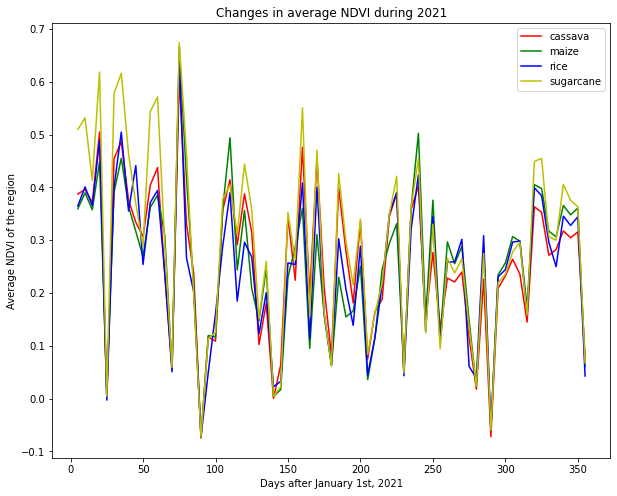

In [25]:
x_axis = [5 * i for i in range(1, 72)]
colors = ['r', 'g', 'b', 'y']
plt.figure(figsize=(10, 8))
for clr, crop in zip(colors, ndvi_by_crop.index):
    plt.plot(x_axis, ndvi_by_crop.loc[crop].values, color=clr, label=crop)
plt.title("Changes in average NDVI during 2021")
plt.xlabel("Days after January 1st, 2021")
plt.ylabel("Average NDVI of the region")
plt.legend()
plt.show()

## Machine Learning